# COMP90089 Assignment2
Youran Zhou (991504)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
data = pd.read_csv("hypotension_patients_assign-2.csv")
data.head()

,ID,anchor_age,gender,dod,apsiii,LoS,charlson_comorbidity_index
0,1,80,F,NaN,56,7.00,4
1,2,72,F,2137-09-02,49,12.92,6
2,3,82,M,2144-06-18,46,13.13,5
3,4,89,F,2155-12-07,86,4.92,7
4,5,69,F,2136-05-12,102,11.46,8


In [19]:
#Replace Date of Death times with binary (0 or 1)
data.loc[data['dod'].notna(),'dod'] = int(1)
data.loc[data['dod'].isnull(),'dod'] = int(0)
data['dod'] = data['dod'].astype(int)


#Transform Gender column from Categorical Data to Binary:
gender_categorical = pd.get_dummies(data['gender'])

#Concatenate both Data frames:
data = pd.concat([data,gender_categorical], axis = 1)

# Question 1
**Describe via summary statistics the main properties of the profound hypotension cohort.**

## Statistical Summary

In [20]:
data.describe()

,ID,anchor_age,dod,apsiii,LoS,charlson_comorbidity_index,F,M
count,5106.000000,5106.000000,5106.00000,5106.000000,5106.000000,5106.00000,5106.000000,5106.000000
mean,2553.500000,65.552683,0.64434,60.314532,7.053651,5.21700,0.441246,0.558754
std,1474.119568,15.235907,0.47876,28.860171,8.432716,2.57691,0.496585,0.496585
min,1.000000,18.000000,0.00000,3.000000,0.040000,0.00000,0.000000,0.000000
25%,1277.250000,56.000000,0.00000,38.000000,1.960000,4.00000,0.000000,0.000000
50%,2553.500000,67.000000,1.00000,53.000000,4.130000,5.00000,0.000000,1.000000
75%,3829.750000,77.000000,1.00000,78.000000,8.960000,7.00000,1.000000,1.000000
max,5106.000000,91.000000,1.00000,189.000000,103.500000,19.00000,1.000000,1.000000


## Distribution Analysis on Numerical Data

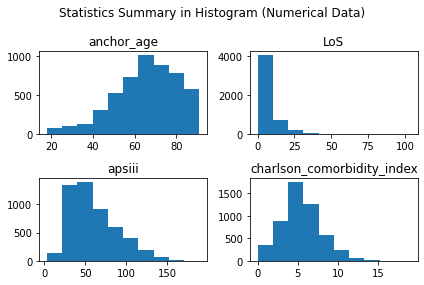

In [21]:
fig, axs = plt.subplots(2, 2)

fig.suptitle('Statistics Summary in Histogram (Numerical Data)')

axs[0, 0].hist(data["anchor_age"],bins = 10)
axs[0, 0].set_title("anchor_age")

axs[1, 0].hist(data["apsiii"],bins = 10)
axs[1, 0].set_title("apsiii")

axs[0, 1].hist(data["LoS"],bins = 10)
axs[0, 1].set_title("LoS")

axs[1, 1].hist(data["charlson_comorbidity_index"],bins = 10)
axs[1, 1].set_title("charlson_comorbidity_index")

fig.tight_layout()
plt.show()



## Distribution Analysis on Categorical Data

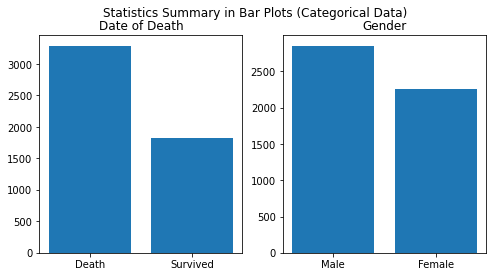

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (8,4))
fig.suptitle('Statistics Summary in Bar Plots (Categorical Data)')
ax1.bar(["Death","Survived"],data["dod"].value_counts().values)
ax1.set_title("Date of Death")

ax2.bar(["Male","Female"],data["gender"].value_counts().values)
ax2.set_title("Gender")

plt.show()

## Pair Plot Analysis Grouped by Death


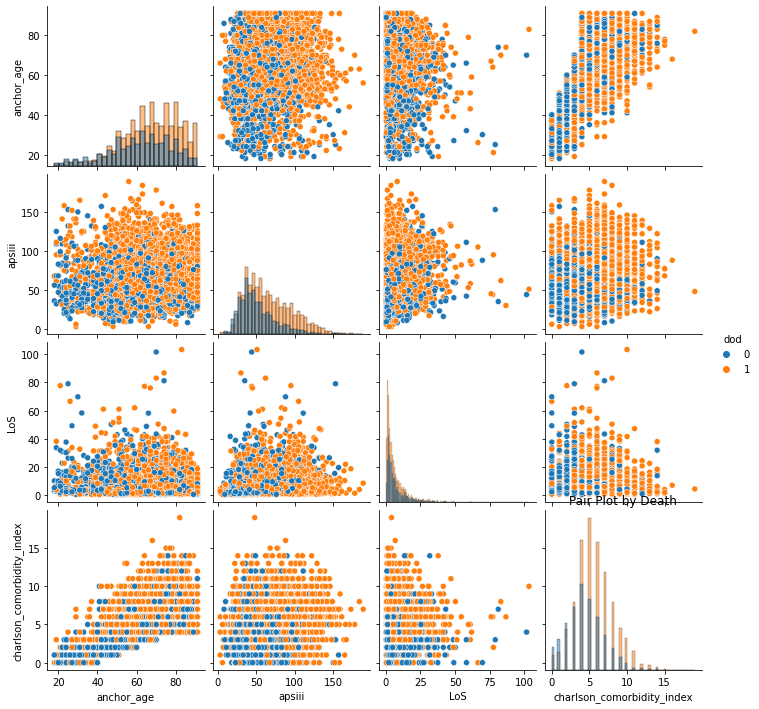

In [23]:
sns.pairplot(data[['anchor_age', 'gender', 'dod', 'apsiii', 'LoS',
       'charlson_comorbidity_index']], hue="dod",diag_kind="hist")

plt.title("Pair Plot by Death")
plt.show()

## Pair Plot Analysis Grouped by Gender

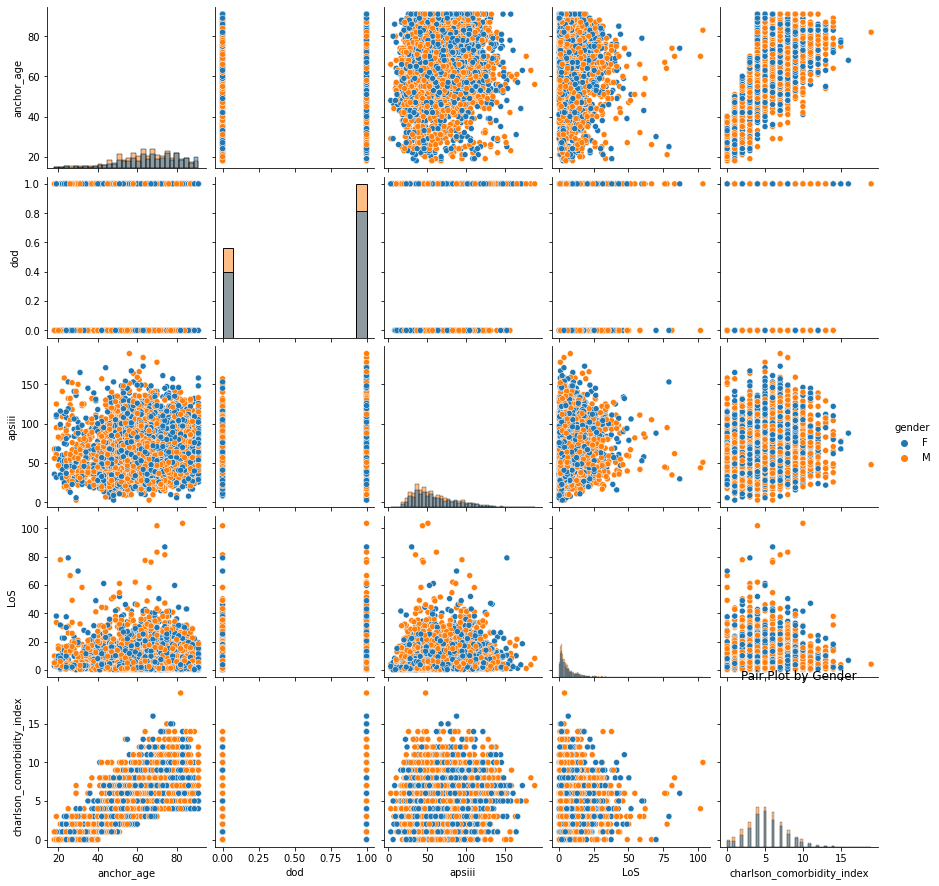

In [24]:
sns.pairplot(data[['anchor_age', 'gender', 'dod', 'apsiii', 'LoS',
       'charlson_comorbidity_index']], hue="gender",diag_kind="hist")
plt.title("Pair Plot by Gender")
plt.show()

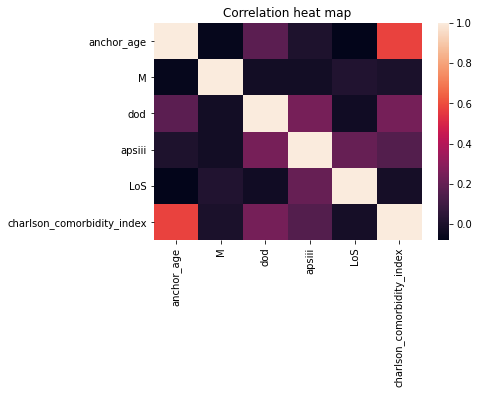

In [25]:
sns.heatmap(data[['anchor_age', 'M', 'dod', 'apsiii', 'LoS',
       'charlson_comorbidity_index']].corr())
plt.title("Correlation heat map")
plt.show()

### Question1 Answer

**We summarize statistics hypotension cohort through a table and plots.**

**Overall, 5106 patients are recorded. The average age is 65.55 with around 64% death rate. The average illness score is 60.31 and the average length of stay in ICU is 7 days. The variance of illness score and LoS is quite large, meaning the extent of severity varies.**

**In The Numerical plots, the anchor_age plot is relative right skewed, and Los, aspiii, and Charlson comorbidity index are left skewed. Especially for LoS, it has a long tail. This indicates that most patients are elders, and some have severe illnesses.**


**From the Categorical Data analysis plots, we have a higher proportion of male patients and an overall higher death rate for profound hypotension.**

**We also grouped the data by dod and gender to see if the dead patient and survived patient or male patient and female patient have different performances. The patients with death outcomes will have a larger aspiii and LoS. The anchorage also shows a positive correlation with the Charlson comorbidity index. (Proofed by correlation heat map) The performance of male and female patients is similar. Thus there is not much differences between male and female patients.**

### Question 2 
**Perform k-means clustering to identify subgroups of patients.**

Use the elbow criteria to identify an adequate number of clusters. Justify your choice. Since
selecting clusters based on elbow criteria is a heuristic, you may select two different
values of k for further analysis. (Up to 300 words. Provide a plot to justify the
number of clusters chosen).

In [26]:
final_data = data.drop(['ID','gender'], axis = 1)
final_data.head()

,anchor_age,dod,apsiii,LoS,charlson_comorbidity_index,F,M
0,80,0,56,7.00,4,1,0
1,72,1,49,12.92,6,1,0
2,82,1,46,13.13,5,0,1
3,89,1,86,4.92,7,1,0
4,69,1,102,11.46,8,1,0


In [27]:
columns = final_data.columns
scaler = Normalizer()

transformer = scaler.fit(final_data) 

final_data = transformer.transform(final_data)

final_data = pd.DataFrame(final_data, columns=columns)

## K-mean Clustering

In [28]:
sse = []
for i in tqdm(range(1,11)):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(final_data)
    sse.append(kmeans.inertia_)

100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


## Sum of squared distances Elbow Method

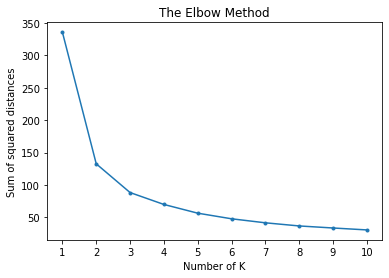

In [29]:
plt.subplot()
plt.plot(range(1,11), sse,".-")
plt.xticks(range(1,11))
plt.xlabel('Number of K')
plt.ylabel('Sum of squared distances')
plt.title('The Elbow Method')
plt.show()

## Silhouette score

In [30]:
silhouette = []
for i in tqdm(range(2,11)):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(final_data)
    silhouette.append(silhouette_score(final_data, kmeans.labels_))

100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


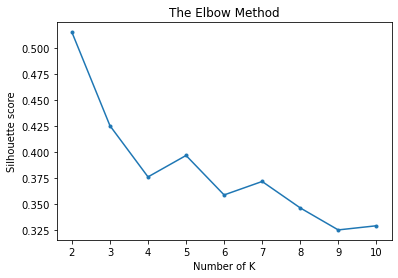

In [31]:
plt.subplot()
plt.plot(range(2,11), silhouette,".-")
plt.xticks(range(2,11))
plt.xlabel('Number of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method')
plt.show()



### Question 2 Answer

**We perform a K-means clustering to identify subgroups of patients. However, one of the key problems of K-means is we must choose the most suitable K by ourselves. Here we use an Elbow method to find the best K. We use from 1 to 10 as our K values and fit 10 Kmean models. We used the inertia of each model(Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided) to make the plot. For the elbow plot, we aim to find the elbow point(key point) to indicate a significant improvement in this K value. Thus, if we look at the first elbow method we plot, we can see an elbow point at K = 2. Unfortunately, the rest of the plot is relatively smooth. Thus we can not find any significant elbow point in this plot. Then we use another method called Silhouette score[1] to help us find the second suitable value. The silhouette score is the mean silhouette coefficient over all dataset instances. The silhouette coefficient measures how close a point in one cluster is to points in the neighboring clusters, ranging from -1 to 1. The higher silhouette coefficient indicates a better result. We use from 2 to 10 as our K values, fit 9 Kmean models, calculate the silhouette coefficient, and then make a plot. From the plot, we can see the second best value is then K = 3. Thus, we use K = 2 and K = 3 as our K values.**


# Question 3 
**What are the main property differences between the clusters you identified?
Are they related to patient outcomes?** 

Provide visualisation plots that
demonstrate these differences. (Up to 300 words. Also provide plots for visualising
final_datathe distributions between clusters).

In [32]:
clustering_data = final_data.copy()

kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(clustering_data)
label_2 = kmeans_2.predict(clustering_data)

kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(clustering_data)
label_3 = kmeans_3.predict(clustering_data)

final_data["group_2"] = label_2
final_data["group_3"] = label_3

## K = 2 Clustering

### PCA Analysis

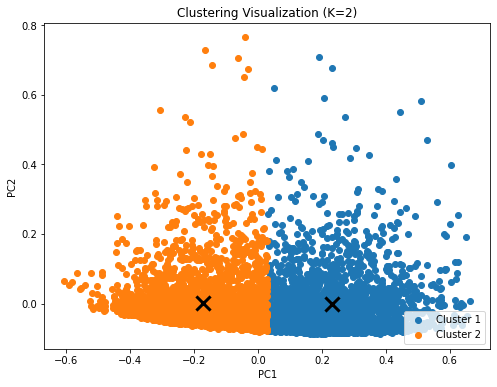

In [33]:
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(clustering_data)

u_labels = np.unique(label_2)
centroids = kmeans_2.cluster_centers_

plt.figure(figsize=(8, 6))
for i in u_labels:
    pc1 = df[label_2 == i , 0]
    pc2 =  df[label_2 == i , 1]
    plt.scatter(pc1 , pc2 , label = "Cluster {}".format((i+1)))
    plt.scatter(pc1.mean(),pc2.mean(),
    marker="x",
    s=200,
    linewidths=3,
    color="black",
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering Visualization (K=2)")
plt.legend(loc = 4)
plt.show()

### Pair Plot Analysis

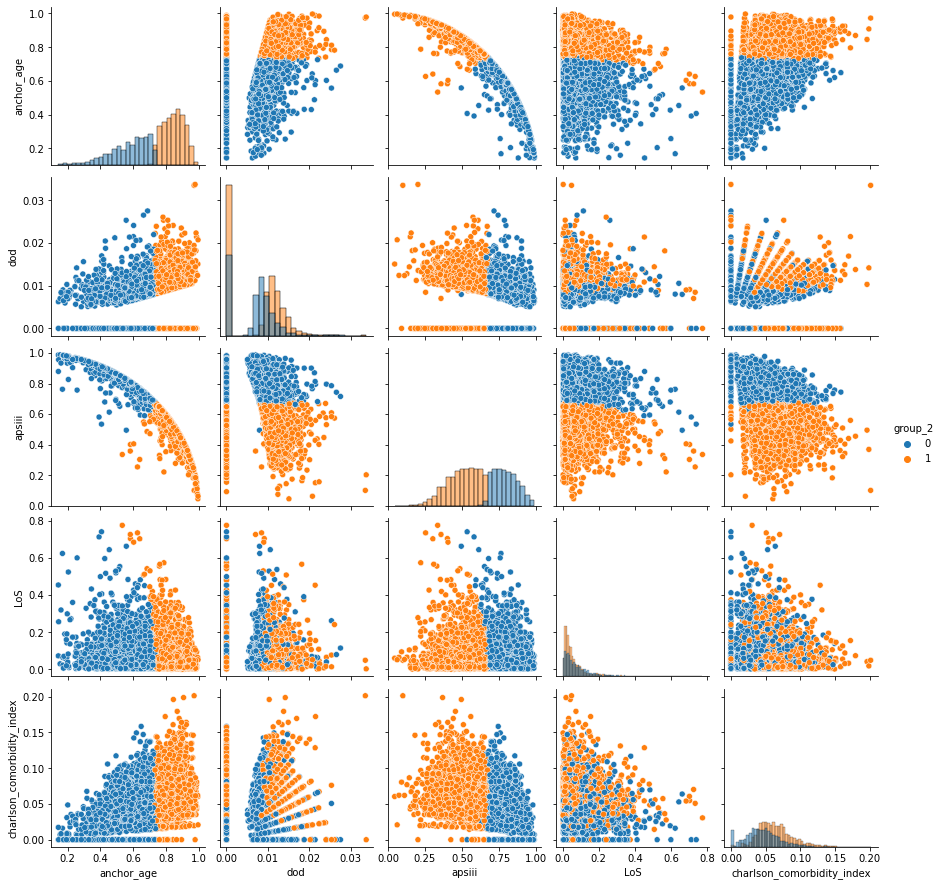

In [34]:
sns.pairplot(final_data[['anchor_age', 'dod', 'apsiii', 'LoS', 'charlson_comorbidity_index','group_2']], hue="group_2",diag_kind="hist")

plt.show()

## K = 3 Clustering

### PCA Analysis

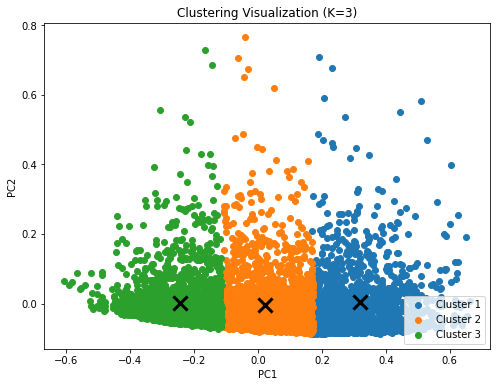

In [35]:
pca = PCA(2) 
#Transform the data
df = pca.fit_transform(clustering_data)

u_labels = np.unique(label_3)
plt.figure(figsize=(8, 6))
for i in u_labels:
    pc1 = df[label_3 == i , 0]
    pc2 =  df[label_3 == i , 1]
    plt.scatter(pc1 , pc2 , label = "Cluster {}".format((i+1)))
    plt.scatter(pc1.mean(),pc2.mean(),
    marker="x",
    s=200,
    linewidths=3,
    color="black",
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering Visualization (K=3)")
plt.legend(loc = 4)
plt.show()

### Pair Plot Analysis

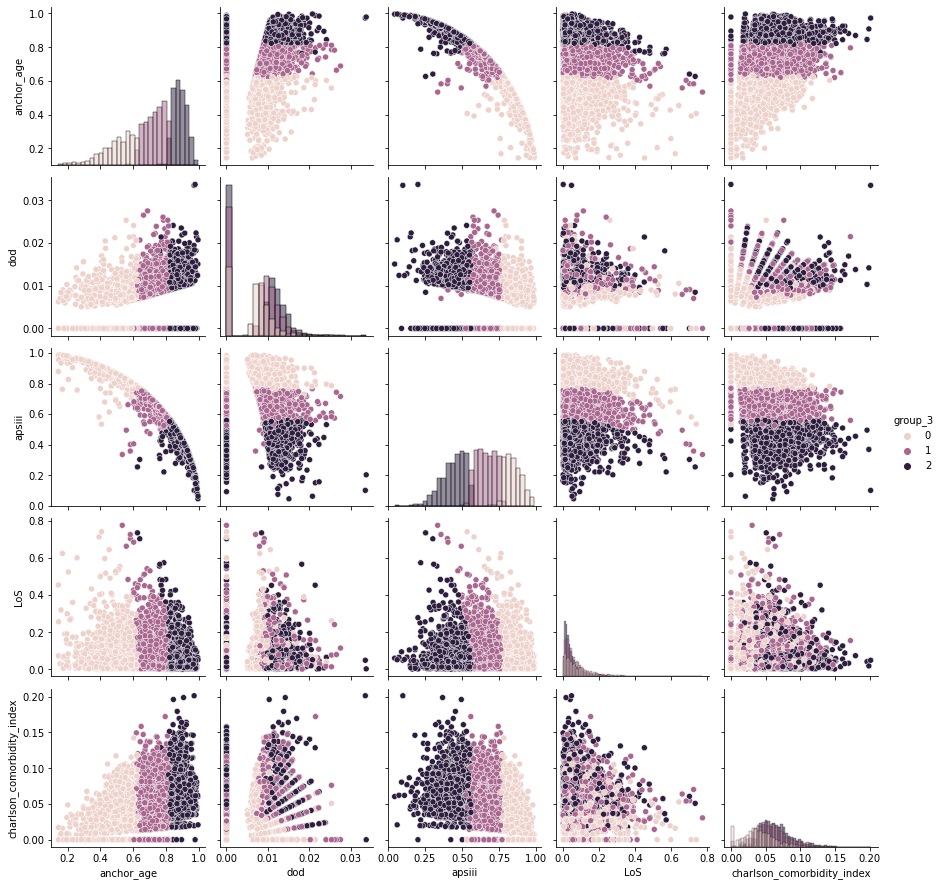

In [36]:
sns.pairplot(final_data[['anchor_age', 'dod', 'apsiii', 'LoS', 'charlson_comorbidity_index','group_3']],
             hue="group_3",diag_kind="hist")

plt.show()

### Question 3 Answer

**\We analyze both when K=2 and K=3 using PCA(Principal component analysis) analysis and Pair plot analysis. The PCA is a dimension reduction method since the patient cohort table contains higher dimensions which are hard for us to visualize. Thus, we use the PCA method and find the first 2 PC (Normally, the first few PCs could provide the most information of the dataset) of the dataset and use a scatter plot to plot the allocated clusters and corresponding cluster centroids. We use a scatter plot of the first two PCs with a different colors to indicate the clusters. These plots do not separate the cluster well in K = 2 and K = 3.**

**Then we further use pair plots to analyze the significant differences. From both plots, we can see that both clustering method use apsiii as the key features. Thus the main property differences between the clusters are the different severity of illness scores; they've been clustered based on the apsiii score into two or three groups. They are related to the patient outcomes; from the pair plot for "dod," we found that the orange group(when k = 2) and light pink group (when k = 3) have a higher death rate as well as the larger apsiii. This indicates that patients with higher apsiii are easier to die.**

## Reference

[1]: # https://medium.com/geekculture/stop-using-the-elbow-method-96bcfbbbe9fd